# A3.2 Classification

* 3.2: Added the code for `_objective_to_actual` and more calls to set the random number seed each place it is needed to help you test your code. Also made small change in `neuralnetworks.py`, so please download `A3code.zip` again and unzip it.
* 3.1: Replaced example output from `python neuralnetworks.py` with correct values.  Added call to `np.random.seed` to set the seed value for the random number generator so your example runs will produce same output as the output included here.

Brent Staab

In this assignment you will define a new class named `NeuralNetworkClassifier` that extends the given class `NeuralNetwork`.  Your new class will reuse most of the code in its parent class, but you will have to define the parts of the code that differ to allow the network to do classification. 

To learn a bit about how to call methods in a parent class, take a look at this
[introduction to inheritance](https://realpython.com/python-super/) and examples of using `super()`.

Start by downloading [A3code.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A3code.zip).  Unzip this and you should see these files:

*  `mlutilities.py`
*  `neuralnetworks.py`
*  `optimizers.py`

If you just run `neuralnetworks.py` you should see the following result.

```
$ python neuralnetworks.py 
scg  [] use_torch=False RMSE 7.266 took 0.001 seconds
scg  [5, 5] use_torch=False RMSE 1.561 took 0.088 seconds
sgd  [5, 5] use_torch=False RMSE 0.856 took 0.040 seconds
adam [5, 5] use_torch=False RMSE 0.247 took 0.044 seconds
scg  [] use_torch=True RMSE 7.266 took 2.290 seconds
scg  [5, 5] use_torch=True RMSE 0.213 took 4.553 seconds
sgd  [5, 5] use_torch=True RMSE 0.803 took 1.420 seconds
adam [5, 5] use_torch=True RMSE 0.261 took 1.434 seconds

```

In [1]:
!python neuralnetworks.py

scg  [] use_torch=False RMSE 7.266 took 0.001 seconds
scg  [5, 5] use_torch=False RMSE 0.797 took 0.087 seconds
sgd  [5, 5] use_torch=False RMSE 0.798 took 0.042 seconds
adam [5, 5] use_torch=False RMSE 0.167 took 0.044 seconds
scg  [] use_torch=True RMSE 7.266 took 2.178 seconds
scg  [5, 5] use_torch=True RMSE 0.191 took 5.382 seconds
sgd  [5, 5] use_torch=True RMSE 0.902 took 1.816 seconds
adam [5, 5] use_torch=True RMSE 0.262 took 1.835 seconds


# Changes Required

The first line of your new class definition will be

```
   .
   .
   .
import neuralnetworks as nn

class NeuralNetworkClassifier(nn.NeuralNetwork):
   .
   .
   .```

Only one change is required in the arguments for all functions, and the change is in the constructor arguments.  The constructor must be dchanged from how it is defined in the `NeuralNetwork` class
```
    def __init__(self, n_inputs, n_hiddens_list, n_outputs, use_torch=False):
```
to
```
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):
```
where ```classes``` is just a list of class integer names, like `[1, 2, 3]`.

The only methods that you will have to include in your new `NeuralNetworkClassifier` are
```
__init__
__repr__
_standardizeT
_unstandardizeT
_forward_pass
_objectiveF
_objective_to_actual
train
use
```

You may introduce new methods that these use, such as
```
_make_indicator_variables```

## Definition of `NeuralNetworkClassifier`

Here is a start at defining your new class.  This bit of code includes everything you will need in the constructor.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys

import torch
import mlutilities as ml  # for ml.draw
import optimizers as opt  # for opt.sgd, opt.adam, and opt.scg

import neuralnetworks as nn

# Extend the nn.NeuralNetwork class to reuse much of its implementation
# Only those methods that must be altered to do classification are defined in NeuralNetworkClassifier
class NeuralNetworkClassifier(nn.NeuralNetwork):

    # Constructor
    def __init__(self, n_inputs, n_hiddens_list, classes, use_torch=False):

        # Force n_hidens_list to be a list
        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetworkClassifier: n_hiddens_list must be a list.')
 
        # Call the constructor for NeuralNetwork, passing in the number of unique class names (ints)
        # as the number of outputs
        super().__init__(n_inputs, n_hiddens_list, len(classes), use_torch)

        # Store as member variables other things needed by instances of this class.
        self.classes = np.array(classes) # to allow argmax in use()
        
        if use_torch:
            self.log = torch.log
            self.exp = torch.exp
        else:
            self.log = np.log
            self.exp = np.exp
    
        self.n_samples = n_inputs
        self.n_outputs = len(classes)

    # insert the rest of your class methods here.
    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, use_torch={self.use_torch})'
        if self.trained:
            str += f'\n   Network was trained for {self.n_epochs} epochs'
            str += f' that took {self.training_time:.4f} seconds. Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
    
    def _standardizeT(self, T):
        return T
    
    def _unstandardizeT(self, T):
        return T
    
    def _forward_pass(self, X):
        return super()._forward_pass(X)
    
    def _objectiveF(self, w, X, T):
        pass
    
    def _objective_to_actual(self, neg_mean_log_likelihood):
        print(f'neg_mean_log_likelihood type({type(neg_mean_log_likelihood)} value({neg_mean_log_likelihood})')
        return self.exp(- neg_mean_log_likelihood)
    
    def train(self, X, T, n_epochs, method='scg',
              verbose=False, save_weights_history=False,
              learning_rate=0.001, momentum_rate=0.0): # only for sgd and adam

        if X.shape[1] != self.n_inputs:
            raise Exception(f'train: number of columns in X ({X.shape[1]}) not equal to number of network inputs ({self.n_inputs})')
        
        if self.use_torch:
            X = torch.tensor(X, dtype=torch.float)  # 32 bit
            T = torch.tensor(T, dtype=torch.float)

        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        T = self._standardizeT(T)
        
        try:
            algo = [opt.sgd, opt.adam, opt.scg][['sgd', 'adam', 'scg'].index(method)]
        except:
            raise Exception("train: method={method} not one of 'scg', 'sgd' or 'adam'")            

        result = algo(self._pack(self.Vs, self.W),
                      self._objectiveF,
                      [X, T], n_epochs,
                      self._gradientF,  # not used if scg
                      eval_f=self._objective_to_actual,
                      learning_rate=learning_rate, momentum_rate=momentum_rate,
                      verbose=verbose, use_torch=self.use_torch,
                      save_wtrace=save_weights_history)

        self._unpack(result['w'])
        self.reason = result['reason']
        self.error_trace = result['ftrace'] # * self.Tstds # to _unstandardize the MSEs
        self.n_epochs = len(self.error_trace) - 1
        self.trained = True
        self.weight_history = result['wtrace'] if save_weights_history else None
        self.training_time = result['time']
        return self
    
    def use(self, X, all_outputs=False):
        return super().use(X, all_outputs)

## Example Tests

Here are some tests of your code and what the results should show.  First the original `NeuralNetwork` class methods are called then the new ones you define in `NeuralNetworkClassifier`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetworks as nn

Here is some toy data.  Input samples have two components, and all values are from 0 to 1.9.  Two targets are defined. The first is the square of of the first input component.  The second is the sine of the second component.

In [4]:
X = np.arange(20).reshape((10, 2)) * 0.1
T = np.hstack((X[:, 0:1]**2, np.sin(X[:, 1:2])))
X.shape, T.shape

((10, 2), (10, 2))

In [5]:
X

array([[0. , 0.1],
       [0.2, 0.3],
       [0.4, 0.5],
       [0.6, 0.7],
       [0.8, 0.9],
       [1. , 1.1],
       [1.2, 1.3],
       [1.4, 1.5],
       [1.6, 1.7],
       [1.8, 1.9]])

In [6]:
T

array([[0.        , 0.09983342],
       [0.04      , 0.29552021],
       [0.16      , 0.47942554],
       [0.36      , 0.64421769],
       [0.64      , 0.78332691],
       [1.        , 0.89120736],
       [1.44      , 0.96355819],
       [1.96      , 0.99749499],
       [2.56      , 0.99166481],
       [3.24      , 0.94630009]])

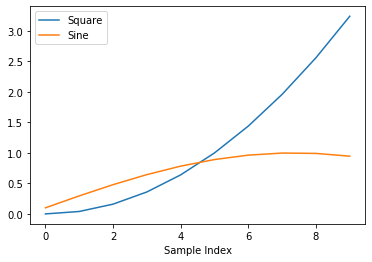

In [7]:
plt.plot(T)
plt.xlabel('Sample Index')
plt.legend(['Square', 'Sine']);

In [8]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)  Network is not trained.

In [9]:
nnet.train(X, T, 50, method='scg')
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0282 seconds. Final objective value is 0.074

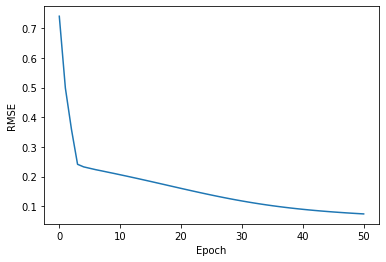

In [10]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

In [11]:
nnet

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0282 seconds. Final objective value is 0.074

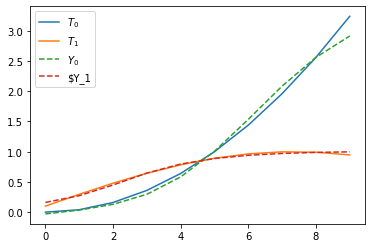

In [12]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

Now with SGD.

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0134 seconds. Final objective value is 0.212


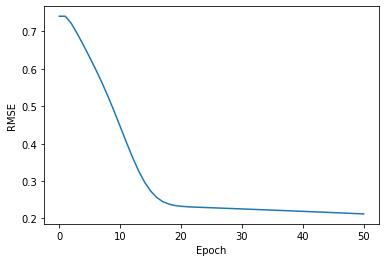

In [13]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet.train(X, T, 50, method='sgd', learning_rate=0.1, momentum_rate=0.5)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

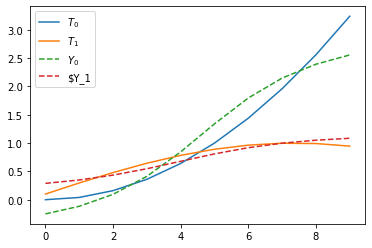

In [14]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

and with Adam

NeuralNetwork(2, [10, 10], 2, use_torch=False)
   Network was trained for 50 epochs that took 0.0141 seconds. Final objective value is 0.037


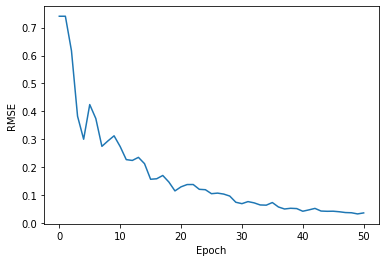

In [15]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2)
nnet.train(X, T, 50, method='adam', learning_rate=0.1)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

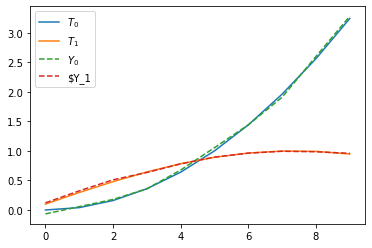

In [16]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

To test the use of pytorch, add `use_torch=True` to the constructor.

NeuralNetwork(2, [10, 10], 2, use_torch=True)
   Network was trained for 50 epochs that took 0.1565 seconds. Final objective value is 0.036


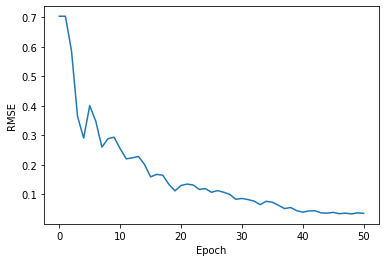

In [17]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet = nn.NeuralNetwork(2, [10, 10], 2, use_torch=True)
nnet.train(X, T, 50, method='adam', learning_rate=0.1)
print(nnet)
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE');

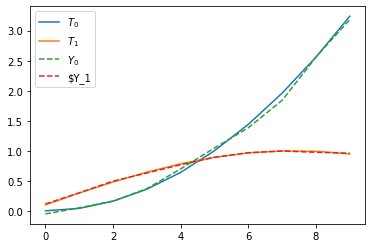

In [18]:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1']);

Now for some tests on the individual new class methods.  First we create some toy classification data.  Each sample has two inputs, randomly chosen from integers 0, 1, and 2.  Target class is 1 if the two input samples are equal, 0 if they are not.

In [19]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

n_samples = 20
X = np.random.choice(3, (n_samples, 2))
T = (X[:, 0:1] == X[:, 1:2]).astype(int)  # where the two inputs are equal
classes = [0, 1]

for x, t in zip(X, T):
    print(f'x = {x}, t = {t}')

x = [2 0], t = [0]
x = [2 2], t = [1]
x = [0 0], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [2 2], t = [1]
x = [0 2], t = [0]
x = [1 0], t = [0]
x = [1 1], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [1 1], t = [1]
x = [0 0], t = [1]
x = [0 2], t = [0]
x = [2 2], t = [1]
x = [1 2], t = [0]
x = [1 1], t = [1]
x = [2 1], t = [0]
x = [2 2], t = [1]
x = [0 2], t = [0]


In [20]:
print(f'{np.sum(T==0)} not equal, {np.sum(T==1)} equal')

8 not equal, 12 equal


In [30]:
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.

nnet_new = NeuralNetworkClassifier(2, [10, 10], [0, 1])
nnet_new

NeuralNetworkClassifier(2, [10, 10], 2, use_torch=False)  Network is not trained.

We will not be standardizing targets T for this network, so we must redefine the two relevant functions so they just return their argument.

In [31]:
nnet_new._standardizeT(T)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [32]:
nnet_new._unstandardizeT(T)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

The standardization functions from the parent class will be available to us.

In [33]:
nnet_new._setup_standardize(X, T)
Xst = nnet_new._standardizeX(X)
Xst

array([[ 1.08347268, -1.47709789],
       [ 1.08347268,  0.98473193],
       [-1.32424438, -1.47709789],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193],
       [-0.12038585, -1.47709789],
       [-0.12038585, -0.24618298],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-0.12038585, -0.24618298],
       [-1.32424438, -1.47709789],
       [-1.32424438,  0.98473193],
       [ 1.08347268,  0.98473193],
       [-0.12038585,  0.98473193],
       [-0.12038585, -0.24618298],
       [ 1.08347268, -0.24618298],
       [ 1.08347268,  0.98473193],
       [-1.32424438,  0.98473193]])

In this test of `_forward_pass` your results will differ, because they depend on the randomly-initialized weight values.

In [34]:
Y, Z = nnet_new._forward_pass(Xst)
Y

array([[ 0.0668058 , -0.14048955],
       [-0.05748557, -0.17183824],
       [ 0.17016075, -0.21828927],
       [-0.00716794, -0.15096359],
       [-0.05748557, -0.17183824],
       [-0.05748557, -0.17183824],
       [ 0.17294163, -0.22197042],
       [ 0.10253499, -0.18600578],
       [ 0.06547823, -0.19174458],
       [ 0.06547823, -0.19174458],
       [ 0.17016075, -0.21828927],
       [ 0.06547823, -0.19174458],
       [ 0.17016075, -0.21828927],
       [ 0.17294163, -0.22197042],
       [-0.05748557, -0.17183824],
       [ 0.04173896, -0.19970731],
       [ 0.06547823, -0.19174458],
       [-0.00716794, -0.15096359],
       [-0.05748557, -0.17183824],
       [ 0.17294163, -0.22197042]])

In [35]:
w = nnet_new._pack(nnet_new.Vs, nnet_new.W)

T_indicator_vars = np.hstack((T, 1 - T))  # this only works for this particular two-class toy data

nnet_new._objectiveF(w, X, T_indicator_vars)

The conversion from objective function, which is being minimized, to the likelihood of the data that we wish to maximize, is done by your new definition of `_objective_to_actual`.  This function is given as its argument the output from `_objectiveF` which is the negative mean log likelihood.  It should convert this to just likelihood. Do this by removing the operations in reverse order.  This is confusing a number of you, so I will give you the correct code here.


    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood * self.n_samples * self.n_outputs)
        
You should set `self.n_samples` in the `train` function.

Now, for the workhorses, the functions the user of your class will use.

In [36]:
nnet_new.train(X, T, 100)

neg_mean_log_likelihood type(<class 'NoneType'> value(None)


TypeError: bad operand type for unary -: 'NoneType'

In [ ]:
Y_classes, Y = nnet_new.use(X)
Y_classes.shape, Y.shape

Let's plot target and predicted classes. Shift the predicted class a bit upward to we can see it.

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Y_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

## Real Data Set

Now download a dataset for a classification problem from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).  Choose one you find interesting.

Load the data into `numpy` arrays for `X` and `T`.  Use your `NeuralNetworkClassifier` to model the data.  Train on all of the data and calculate the number of samples that you correctly classify.  Compare the accuracy for several sizes of networks, numbers of epochs, and optimization algorithms.  Discuss what you find.  Are you able to model the data accurately?

# Grading

A3grader.py will be available soon.  Until it is, conduct your own tests of your code.

# Extra Credit

1. For the data set you have downloaded, randomly partition the data into about 80% for training and 20% for testing.  Discuss the percent of samples correctly classified for train and test partitions and how variations in netowrk size, epochs, and optimization algorithm effect the results.
2. Develop a new version of `optimizers.py`, `neuralnetworks.py` and your `NeuralNetworkClassifier` class that will run on a GPU using pytorch.  Add a keyword argument where neded called `use_gpu` that can be set to `True` to run on GPU.